### Построить регрессию для заданного класса между заданными параметрами.

#### Вариант

Классификатор 1 - Байес,
Классификатор 2 - Логистическая регрессия;

Признаки: malic_acid , nonflavanoid_phenols , magnesium


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# 1. Загрузить датасет WINE.
from sklearn.datasets import load_wine
wine = load_wine(as_frame=True)

In [3]:
# 2. Подготовить выборки: обучающую 70% и тестовую 30%.
def split_dataset(
        x: np.ndarray,
        y: np.ndarray,
        propotion=80) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:

    def get_intervals(ind):
        return ind[0][0], ind[0][-1]
    total_size = x.shape[0]
    train_size = int((propotion * total_size) / 100) - 1
    each_class_on_train = int(train_size / len(set(y)))
    each_class_on_test = int((total_size - train_size) / len(set(y)))

    x_train = np.empty((train_size, ), dtype=x.dtype)
    y_train = np.empty((train_size, ))
    x_test = np.empty((total_size - train_size, ), dtype=x.dtype)
    y_test = np.empty((total_size - train_size, ))

    for idx, c in enumerate(set(y)):
        min, max = get_intervals(np.where(y == c))

        inds = np.random.randint(min, max, size=each_class_on_train)
        x_train[
            idx * each_class_on_train:
            idx * each_class_on_train + each_class_on_train] = x[inds]
        y_train[
            idx * each_class_on_train:
            idx * each_class_on_train + each_class_on_train
        ] = y[inds]

        inds = np.random.randint(min, max, size=each_class_on_test)
        x_test[
            idx * each_class_on_test:
            idx * each_class_on_test + each_class_on_test] = x[inds]
        y_test[
            idx * each_class_on_test:
            idx * each_class_on_test + each_class_on_test
        ] = y[inds]
    return x_train, y_train, x_test, y_test


def extract_x_factors(
    data: pd.DataFrame,
    factors: list[str]
) -> np.ndarray:
    dtype = [(factor, data[factor].dtype) for factor in factors]
    result = np.zeros((len(data), ), dtype=dtype)
    for factor in factors:
        result[factor] = data[factor].to_numpy()
    return result


FACTORS = [
    'malic_acid',
    'nonflavanoid_phenols',
    'magnesium'
]
data = extract_x_factors(
    wine.data,
    FACTORS
)

x_train, y_train, x_test, y_test = split_dataset(
    data,
    wine.target,
    propotion=70
)

In [4]:
def merge_x_y(x, y) -> np.ndarray:
    new_dt = np.dtype(
        list(x.dtype.descr) +
        [('target', y_train.dtype)])
    merged = np.zeros(
        x.shape[0],
        dtype=new_dt)
    for name in x.dtype.names:
        merged[name] = x[name]
    merged['target'] = y
    return merged

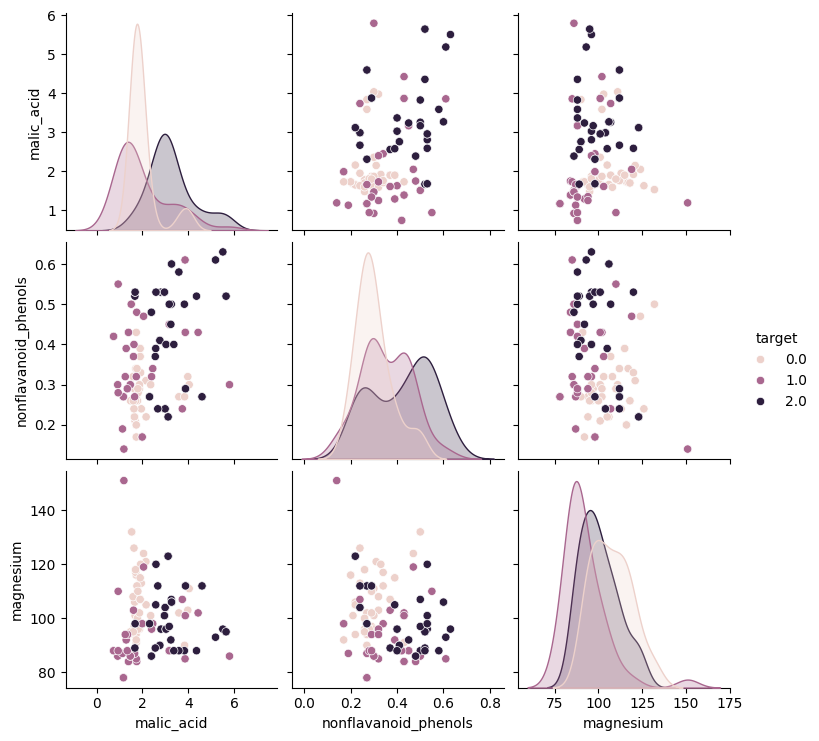

In [5]:
import seaborn as sns
dataset = merge_x_y(x_train, y_train)
dataset = pd.DataFrame(dataset)
sns.pairplot(dataset, hue='target')

In [6]:
# 3. Построить указанные в задании классификаторы.
# 4. Применить указанные классификаторы к каждой паре из указанных в варианте задания признаков.

from sklearn.naive_bayes import (
    GaussianNB
)
from sklearn.linear_model import (
    LogisticRegression,
)


bss = {}
lrr = {}
for f1 in FACTORS:
    for f2 in FACTORS:
        if f1 == f2:
            continue

        # Классификатор 1 - Байес
        br = GaussianNB()
        br.fit(dataset[[f1, f2]], dataset['target'])
        bss[(f1, f2)] = br

        # Классификатор 2 - Логистическая регрессия
        lr = LogisticRegression()
        lr.fit(dataset[[f1, f2]], dataset['target'])
        lrr[(f1, f2)] = lr

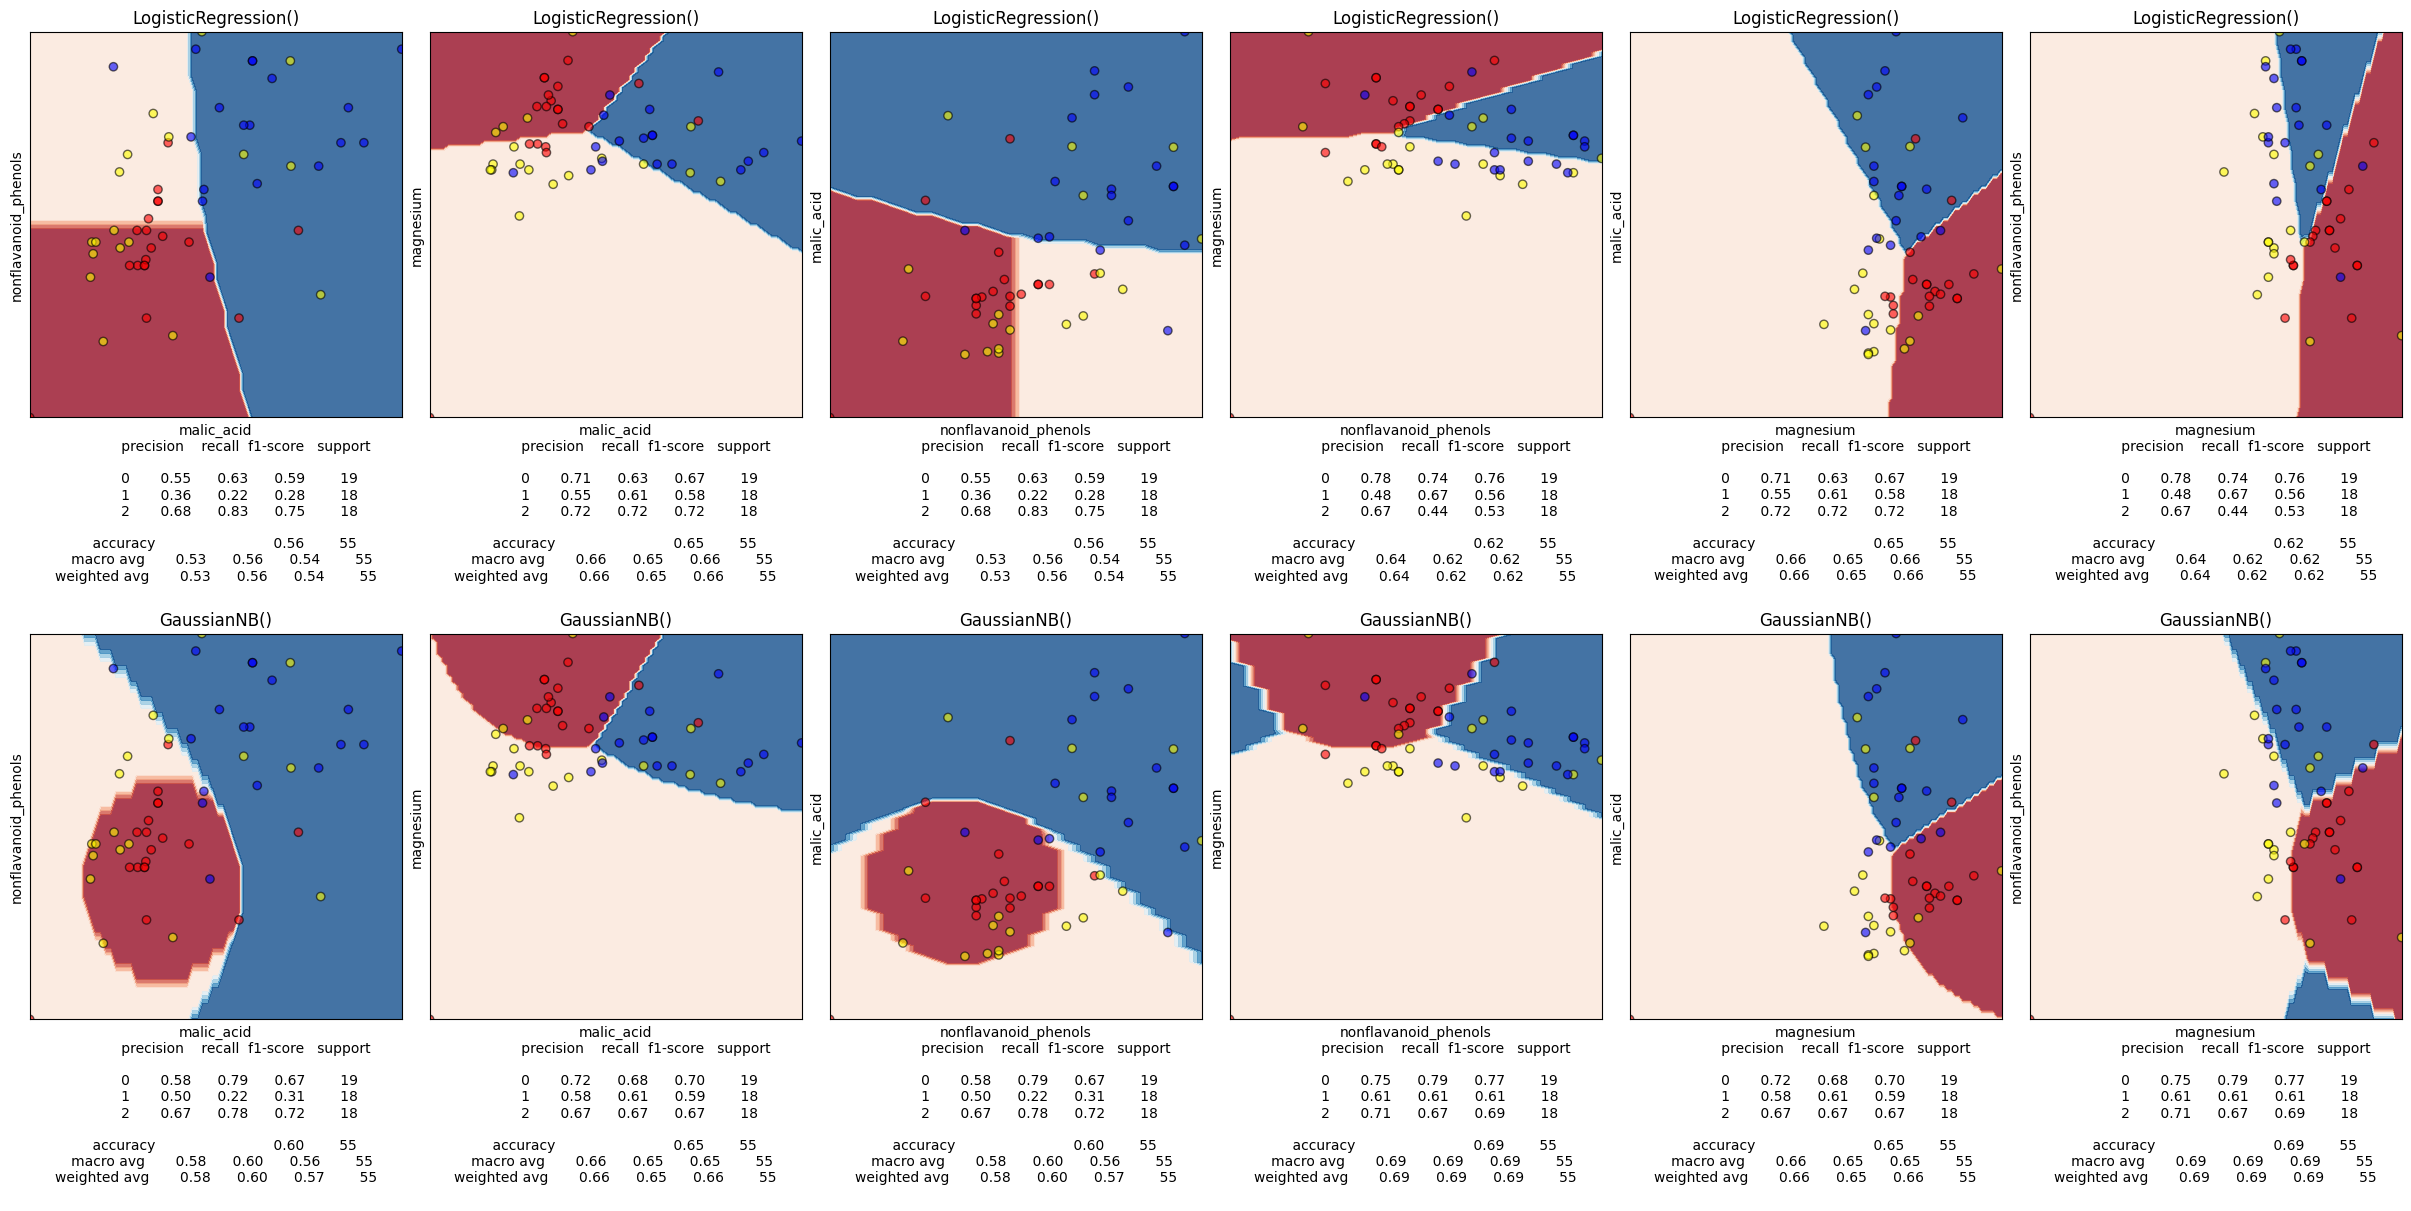

In [7]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import classification_report

fig, axes = plt.subplots(2, len(lrr.values()), layout='constrained')
fig.set_size_inches(24, 12)
i = 1

test_dataset = pd.DataFrame(merge_x_y(x_test, y_test))

cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", 'yellow', "#0000FF"])

ax_pos = 0
for upk in zip(lrr.keys(), lrr.values(), bss.values()):
    f1f2, clf_lrr, clf_bss = upk
    f1, f2 = f1f2

    # lrr_predicted = clf.predict()
    for idx, clf in enumerate([clf_lrr, clf_bss]):
        ax = axes[idx][ax_pos]
        score = clf.score(test_dataset[[f1, f2]].astype(
            'int32'), test_dataset['target'].astype('int32'))
        DecisionBoundaryDisplay.from_estimator(
            clf, test_dataset[[f1, f2]], cmap=cm, alpha=0.8, ax=ax
        )

        # Plot the testing points
        ax.scatter(
            x_test[f1],
            x_test[f2],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(x_test[f1].min(), x_test[f1].max())
        ax.set_ylim(x_test[f2].min(), x_test[f2].max())
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(str(clf))
        ax.set_ylabel(f2)
        ax.set_xlabel('\n'.join([f1, classification_report(
            test_dataset['target'].astype('int32'), clf.predict(test_dataset[[f1, f2]]))]))
    ax_pos += 1

plt.show()

### 6. Выбрать наилучшую комбинацию пару признаков и классификатора.

GaussianNB

Признаки:
nonflavanoid_phenols , magnesium

#### 7. Вывод

Исходя из эмпирических наблюдений, а также из полученных метрик, в ходе проведённой практической работы, для классификации по признакам, находящимся в относительно небольшой близости друг относительно друг наиболее подходящим методом решения задачи классификации является Баесовский подход, так как он даёт наиболее гибкое разделение пространства признаков в сравнении с логистической регрессией